In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data preprocessing

In [2]:
adata = sc.read_h5ad('data/Jiaxu2017_filtered.h5ad')

In [3]:
if not isinstance(adata.X, np.ndarray):
    adata.X = adata.X.toarray()

In [4]:
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
adata

AnnData object with n_obs × n_vars = 604 × 13771
    obs: 'Sample_ID', 'Experiment', 'Day', 'Number of Alignments', 'Cell Quality Control', 'Outlier', 'Subpopulations', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'geneid', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

### PCA and UMAP plots

In [7]:
obs_time = 'Day'

In [8]:
adata.obs['Day'].unique()

['d0', 'd1', 'd5', 'd7', 'd10', 'd30']
Categories (6, object): ['d0', 'd1', 'd5', 'd7', 'd10', 'd30']

In [9]:
sorted_time = ['d0', 'd1', 'd5', 'd7', 'd10', 'd30']
adata.obs[obs_time].cat.reorder_categories(sorted_time, inplace=True)

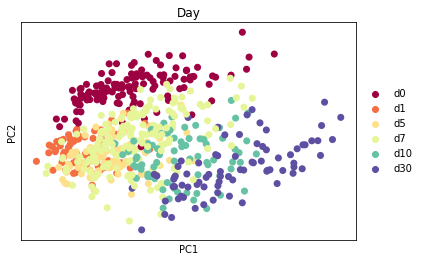

In [10]:
sc.tl.pca(adata)
sc.pl.pca(adata, color=obs_time, palette=plt.cm.Spectral.name)

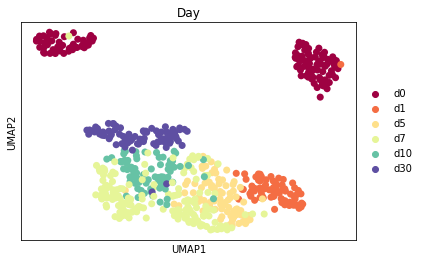

In [11]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=obs_time, palette=plt.cm.Spectral.name)

### CytoTRACE pseudotime

In [12]:
import scvelo as scv
from cellrank.tl.kernels import CytoTRACEKernel

sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

ctk = CytoTRACEKernel(adata)

This detected 2269 highly variable genes. 
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


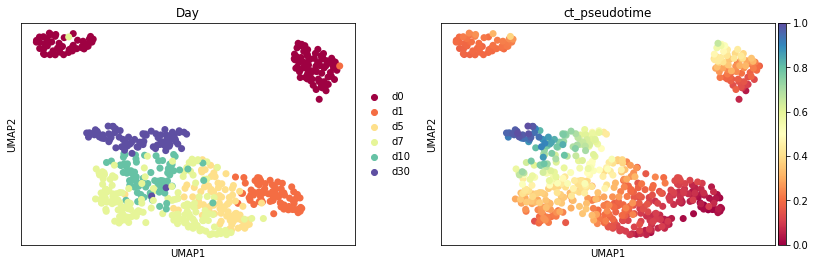

In [13]:
sc.pl.umap(adata, color=[obs_time, 'ct_pseudotime'], cmap=plt.cm.Spectral.name)

### Cell complexity index (CCI) and gene complexity index (GCI)

In [14]:
import scipy.stats as ss
from scipy.sparse.linalg import eigs

def complexity_index(mcg):
    mgc = np.transpose(mcg)
    
    kc0 = np.sum(mcg, axis=1)
    kg0 = np.sum(mcg, axis=0)
    
    mcc = np.dot(mcg / np.transpose([kc0]), mgc / np.transpose([kg0]))
    
    e_val, e_vec = eigs(mcc)    
    cci = np.real(e_vec[:, 1])
    
    scc = ss.spearmanr(kc0, cci)[0]
    if scc < 0:
        cci = - cci
        
    gci = np.dot(mgc, np.transpose([cci])).flatten() / kg0
    
    cci = (cci - np.min(cci)) / (np.max(cci) - np.min(cci))
    gci = (gci - np.min(gci)) / (np.max(gci) - np.min(gci))
    
    return cci, gci

In [15]:
cci, gci = complexity_index(adata.X)

In [16]:
adata.obs['cci_pseudotime'] = 1 - cci

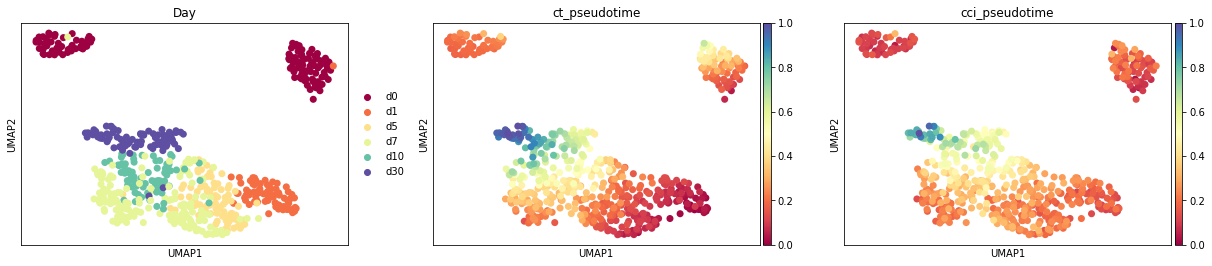

In [17]:
sc.pl.umap(adata, color=[obs_time, 'ct_pseudotime', 'cci_pseudotime'], cmap=plt.cm.Spectral.name)

### Gene diversity

In [18]:
adata.obs['gene_diversity'] = np.sum(adata.X, axis=1)

### Box plots of gene diversity, CytoTRACE pseudotime and CCI pseudotime

In [19]:
time_colors = dict(zip(sorted_time, adata.uns['{}_colors'.format(obs_time)]))

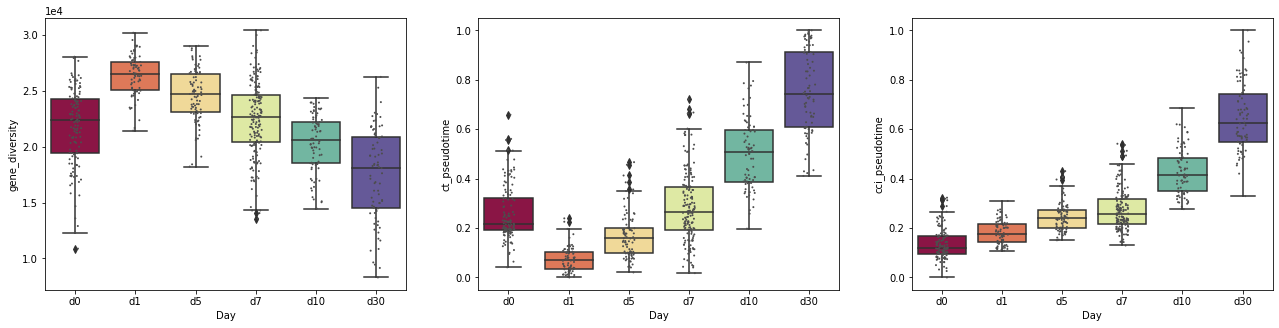

In [20]:
f, axes = plt.subplots(1, 3, figsize=(22, 5))

keys = ['gene_diversity', 'ct_pseudotime', 'cci_pseudotime']

n = 0
for key in keys:
    sns.boxplot(x=obs_time, y=key, data=adata.obs, palette=time_colors, ax=axes[n])
    sns.stripplot(x=obs_time, y=key, data=adata.obs, size=2.0, color=".3", linewidth=0, ax=axes[n])
    n += 1

axes[0].ticklabel_format(style='sci', scilimits=(-1,2), axis='y')  
plt.show()

### Calculate the complexity of each order N by recursion

In [21]:
def cg_complexity(mcg, nmax=30):
    mcg = mcg.astype(np.float64)
    mgc = np.transpose(mcg)
    
    kc = []
    kg = []
    
    kc.append(np.sum(mcg, axis=1))
    kg.append(np.sum(mcg, axis=0))

    for n in range(1, nmax):       
        kc.append(np.dot(mcg, np.transpose([kg[n-1]])).flatten() / kc[0])
        kg.append(np.dot(mgc, np.transpose([kc[n-1]])).flatten() / kg[0])

    kc = np.array(kc)
    kg = np.array(kg)
    
    max_kc = np.max(kc, axis=1).reshape(kc.shape[0], 1)
    min_kc = np.min(kc, axis=1).reshape(kc.shape[0], 1)
    kc = (kc - min_kc) / (max_kc - min_kc)

    max_kg = np.max(kg, axis=1).reshape(kg.shape[0], 1)
    min_kg = np.min(kg, axis=1).reshape(kg.shape[0], 1)
    kg = (kg - min_kg) / (max_kg - min_kg)
    
    return kc, kg

In [22]:
kc, kg = cg_complexity(adata.X)

### Cell complexity as a function of complexity order N.

In [23]:
n_list = range(0, 10, 2)

for n in n_list:
    adata.obs['kc{}'.format(n)] = 1 - kc[n]

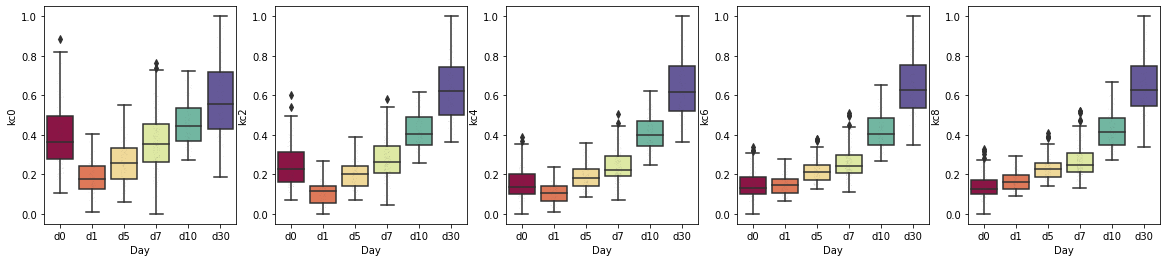

In [24]:
f, axes = plt.subplots(1, len(n_list), figsize=(20, 4))

keys = ['kc{}'.format(n) for n in n_list]

n = 0
for key in keys:
    sns.boxplot(x=obs_time, y=key, data=adata.obs, palette=time_colors, ax=axes[n])
    sns.stripplot(x=obs_time, y=key, data=adata.obs, size=0.3, color=".3", linewidth=0, ax=axes[n])
    n += 1
    
plt.show()

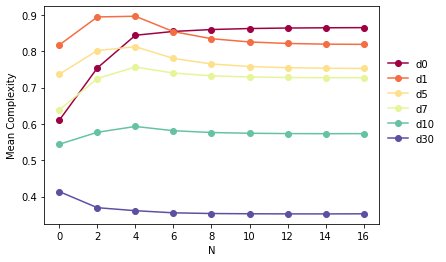

In [25]:
n_list = range(0, 18, 2)

m = 0
for t in sorted_time:
    meankc_list = []
    for n in n_list:
        meankc = np.mean(kc[n][adata.obs[obs_time]==t])
        meankc_list.append(meankc)
    plt.plot(n_list, meankc_list, marker='o', c=adata.uns['{}_colors'.format(obs_time)][m], label=t)
    m += 1
    
plt.legend(bbox_to_anchor=(1.0, 0.8), frameon=False)
plt.ylabel('Mean Complexity')
plt.xlabel('N')
plt.show()

### Cells sorted by Nth-order complexity and CCI

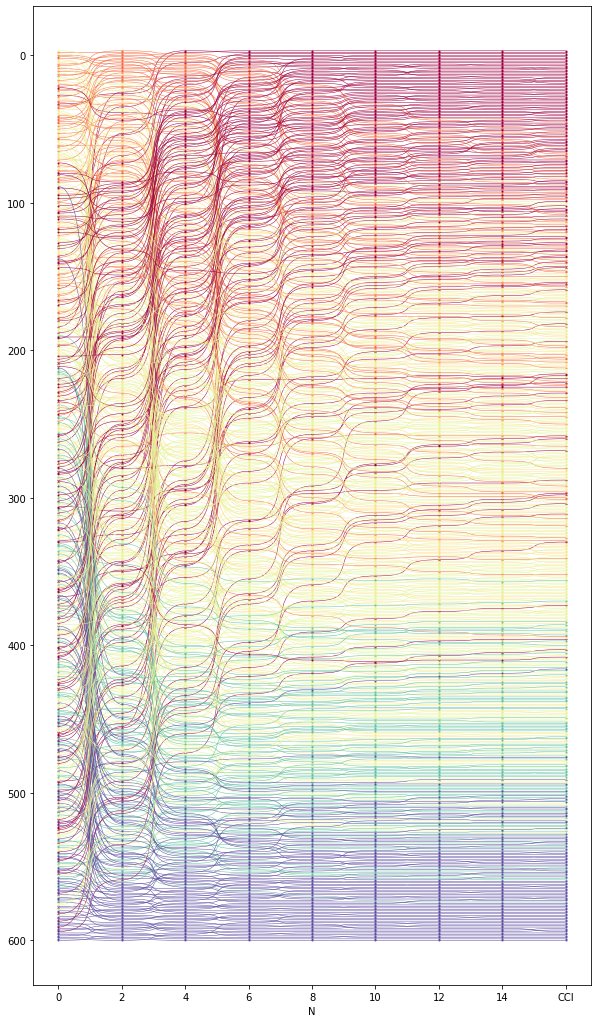

In [26]:
from matplotlib.path import Path
import matplotlib.patches as patches

ncells = adata.X.shape[0]
colors = [time_colors[day] for day in adata.obs[obs_time]]

N_list = range(0, 16, 2)
t = []

for N in N_list:
    arg_idx = dict(zip(np.argsort(kc[N]), range(ncells)))
    t.append([arg_idx[i] for i in range(ncells)])
    
arg_idx = dict(zip(np.argsort(cci), range(ncells)))
t.append([arg_idx[i] for i in range(ncells)])

t = np.array(t)
t = np.transpose(t)

fig, ax = plt.subplots(figsize=(10, 18))

indent = 0.8

for tj, color in zip(t, colors):
    ax.scatter(np.arange(len(tj)), tj, marker='o', color=color, s=1.0, zorder=3)
    verts = [(i + d, tij) for i, tij in enumerate(tj) for d in (-indent, 0, indent)][1:-1]
    codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=0.5, edgecolor=color)
    ax.add_patch(patch)

xticks = []
xticks.extend([str(i) for i in N_list])
xticks.append('CCI')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels(xticks)
yticks = [0, 100, 200, 300, 400, 500, 600]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks[::-1])
ax.set_xlabel('N')
plt.show()

### The ability of gene diversity and complexity to distinguish developmental stages

In [27]:
cell_gci = adata.X * gci
cell_mean_gci = np.sum(cell_gci, axis=1) / np.sum(adata.X, axis=1)

diversity = adata.obs['gene_diversity']
diversity_gci = np.transpose(np.vstack((diversity, cell_mean_gci)))

mean_diversity = np.mean(diversity)
mean_gci = np.mean(cell_mean_gci)

adata.obsm['X_diversity_gci'] = diversity_gci

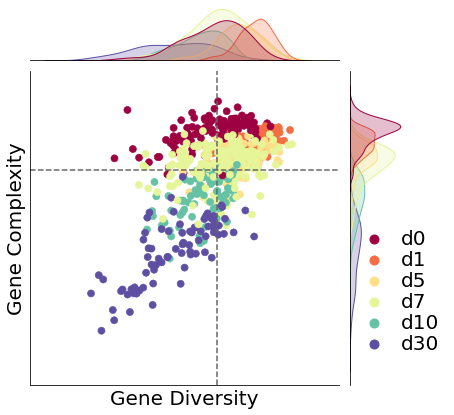

In [28]:
fontsize = 20

adata.obs['mean_gci'] = cell_mean_gci

g = sns.jointplot(x='gene_diversity',
                  y='mean_gci',
                  hue='Day',
                  s=50,
                  palette=adata.uns['Day_colors'],
                  edgecolor=None,
                  data=adata.obs)

g.ax_joint.legend_._visible=False
g.fig.legend(ncol=1, 
           bbox_to_anchor=(1.1, 0.5),
           markerscale=1.5,
           labelspacing=0.1,
           fontsize=fontsize,
           handlelength=1,
           frameon=False)

g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xticklabels([])
g.ax_joint.set_yticklabels([])
g.ax_joint.set_xlabel('Gene Diversity', fontsize=fontsize)
g.ax_joint.set_ylabel('Gene Complexity', fontsize=fontsize)
g.ax_marg_x.set_yticks([])

g.ax_joint.axvline(mean_diversity, color='#666666', linestyle='--')
g.ax_joint.axhline(mean_gci, color='#666666', linestyle='--')

plt.show()

### Silhouette coefficient of gene complexity as a function of complexity order N

In [29]:
time_unique = adata.obs[obs_time].unique()
time_dict = dict(zip(sorted_time, range(len(time_unique))))
time_order = [time_dict[t] for t in adata.obs[obs_time]]

reverse_list = [i for i in range(len(time_unique))]
reverse_list.reverse()
reverse_time_dict = dict(zip(sorted_time, reverse_list))
reverse_time_order = [reverse_time_dict[t] for t in adata.obs[obs_time]] 

In [30]:
from sklearn.metrics import silhouette_score

n_list = range(1, 13, 2)
mean_kg_list = []
for n in n_list:
    cell_kg = adata.X * kg[n]
    cell_mean_kg = np.sum(cell_kg, axis=1) / np.sum(adata.X, axis=1)
    mean_kg_list.append(cell_mean_kg)
    
mean_kg_list = np.array(mean_kg_list)

shc_kg = []
shc_kg.append(silhouette_score(np.array(adata.obs['gene_diversity']).reshape(-1, 1), reverse_time_order))
for mean_kg in mean_kg_list:
    shc_kg.append(silhouette_score(np.array(mean_kg).reshape(-1, 1), reverse_time_order))

shc_ct = silhouette_score(np.array(1-adata.obs['ct_pseudotime']).reshape(-1, 1), reverse_time_order)

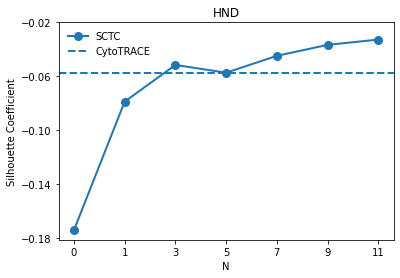

In [31]:
plt.plot(shc_kg, marker='o', markersize=8, linewidth=2, label='SCTC')
plt.axhline(shc_ct, linestyle='--', linewidth=2, label='CytoTRACE')

plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=[0, 1, 3, 5, 7, 9, 11])
plt.yticks([-0.18, -0.14, -0.10, -0.06, -0.02])

plt.xlabel('N')
plt.ylabel('Silhouette Coefficient')

plt.legend(frameon=False)
plt.title('HND')

plt.show()

### 600 randomly selected HND genes sorted by Nth-order complexity and GCI

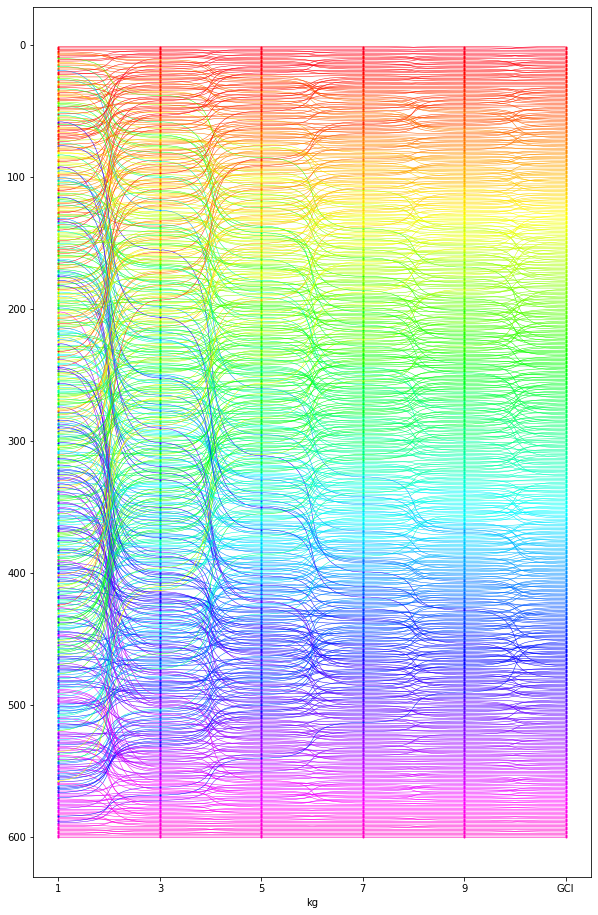

In [32]:
n_choice = 600
choice = np.random.choice(kg.shape[1], n_choice, replace=False)
choice_kg = kg[:, choice]
choice_gci = gci[choice]

cmap = plt.get_cmap(plt.cm.gist_rainbow.name, n_choice)
cmap_colors = cmap(np.arange(0, cmap.N))[::-1]

choice_gci_argsorted = np.argsort(choice_gci)
gene_color = dict(zip(choice_gci_argsorted, cmap_colors))

colors = [gene_color[i] for i in range(n_choice)]

N_list = range(1, 11, 2)
t = []

for N in N_list:
    arg_idx = dict(zip(np.argsort(choice_kg[N]), range(n_choice)))
    t.append([arg_idx[i] for i in range(n_choice)])

arg_idx = dict(zip(np.argsort(choice_gci), range(n_choice)))
t.append([arg_idx[i] for i in range(n_choice)])    
    
t = np.array(t)
t = np.transpose(t)

fig, ax = plt.subplots(figsize=(10, 16))

indent = 0.8

for tj, color in zip(t, colors):
    s = ax.scatter(np.arange(len(tj)), tj, marker='o', color=color, s=1.0, zorder=3)
    verts = [(i + d, tij) for i, tij in enumerate(tj) for d in (-indent, 0, indent)][1:-1]
    codes = [Path.MOVETO] + [Path.CURVE4] * (len(verts) - 1)
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=0.5, edgecolor=color)
    ax.add_patch(patch)

xticks = []
xticks.extend([str(i) for i in N_list])
xticks.append('GCI')
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(xticks)
yticks = [0, 100, 200, 300, 400, 500, 600]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks[::-1])
ax.set_xlabel('kg')
plt.show()

### Genes of different GCI are associated with specific developmental stages

In [33]:
argsort_gci = np.argsort(gci)
argsort_gci = np.flip(argsort_gci)

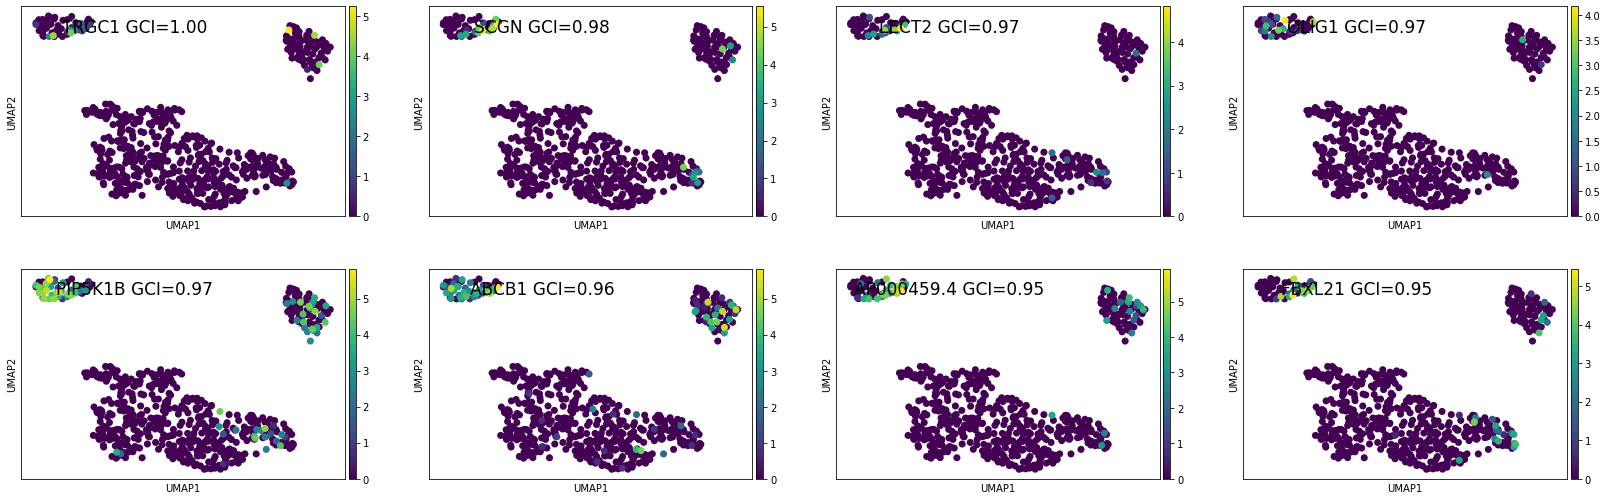

In [34]:
ntop = 8

top_gene = [adata.var.index[argsort_gci[i]] for i in range(ntop)]

axes = sc.pl.umap(adata, color=top_gene, show=False)

n = 0
for ax in axes:
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    
    ax.set_title('{} GCI={:.2f}'.format(top_gene[n], gci[argsort_gci[n]]), x=0.35, y=0.95, pad=-15, fontsize=17)
    n += 1
    
plt.show()

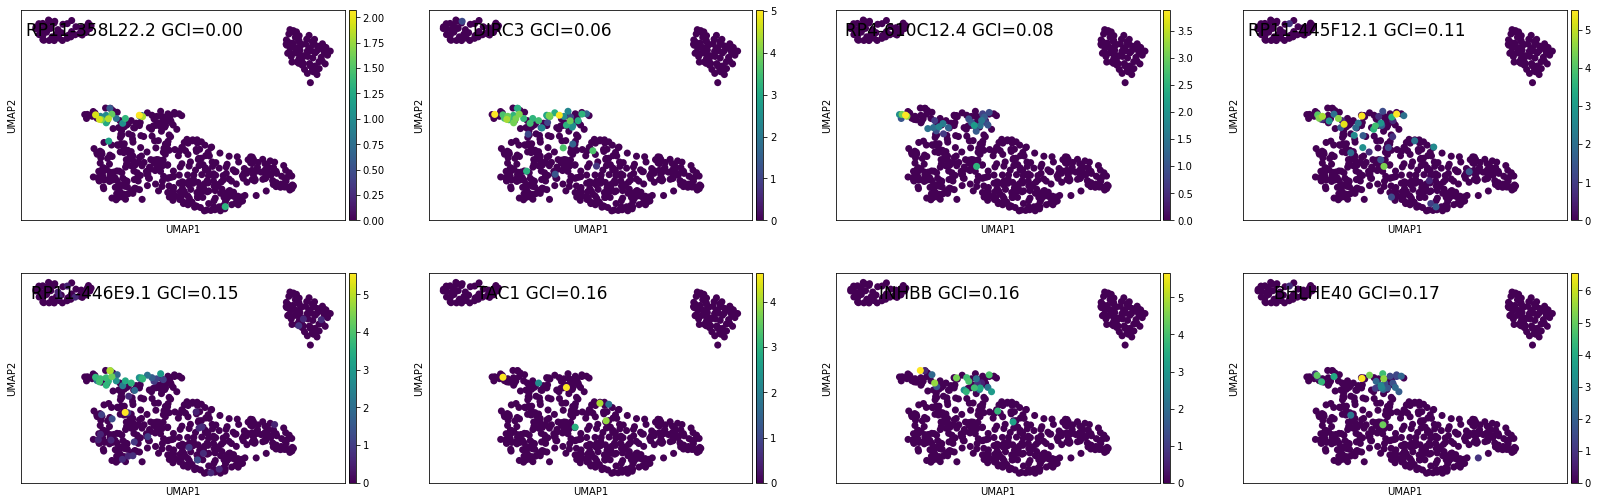

In [35]:
nbottom = ntop

bottom_gene = [adata.var.index[argsort_gci[-i]] for i in range(1, nbottom+1)]

axes = sc.pl.umap(adata, color=bottom_gene, show=False)

n = 1
for ax in axes:
    cbar = ax.collections[0].colorbar
    
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    
    ax.set_title('{} GCI={:.2f}'.format(bottom_gene[n-1], gci[argsort_gci[-n]]), x=0.35, y=0.95, pad=-15, fontsize=17)
    n += 1

plt.show()

In [36]:
ntop = 100
top_gene = [adata.var.index[argsort_gci[i]] for i in range(ntop)]

top_gene_expr = []

for i in range(ntop):
    gene = top_gene[i]
    top_gene_expr.append([])
    for t in sorted_time:
        gene_expr = adata.X[adata.obs[obs_time]==t, adata.var.index==gene].flatten()
        top_gene_expr[i].append(np.mean(gene_expr))
        
top_gene_expr = np.array(top_gene_expr)

Text(0, 0.5, 'Gene Expression')

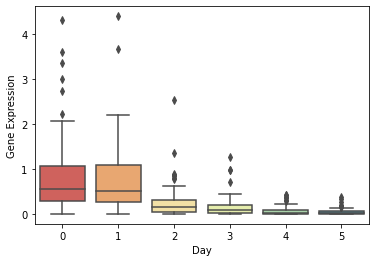

In [37]:
sns.boxplot(data=top_gene_expr, palette=plt.cm.Spectral.name)
plt.xlabel('Day')
plt.ylabel('Gene Expression')

In [38]:
nbottom = ntop
bottom_gene = [adata.var.index[argsort_gci[-i]] for i in range(1, nbottom+1)]
time_sort = adata.obs[obs_time].unique()

bottom_gene_expr = []

for i in range(nbottom):
    gene = bottom_gene[i]
    bottom_gene_expr.append([])
    for t in sorted_time:
        gene_expr = adata.X[adata.obs[obs_time]==t, adata.var.index==gene].flatten()
        bottom_gene_expr[i].append(np.mean(gene_expr))
        
bottom_gene_expr = np.array(bottom_gene_expr)

<AxesSubplot:>

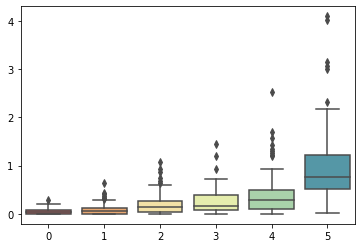

In [39]:
sns.boxplot(data=bottom_gene_expr, palette=plt.cm.Spectral.name)